<a href="https://colab.research.google.com/github/sakp7/Traffic-Sign-Prediction/blob/main/Traffic_Sign_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ramsaketh","key":"76d2cd90f36d80bf7a36e80aee61c295"}'}

In [2]:
!pip install -q kaggle

In [3]:
# The Kaggle API client expects this file to be in ~/.kaggle, so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
# Creating directory and changing the current working directory
!mkdir traffic_sign_dataset
%cd traffic_sign_dataset

/content/traffic_sign_dataset


In [5]:
# Searching for dataset
!kaggle datasets list -s gtsrb-german-traffic-sign

ref                                                                title                                               size  lastUpdated          downloadCount  voteCount  usabilityRating  
-----------------------------------------------------------------  -------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
meowmeowmeowmeowmeow/gtsrb-german-traffic-sign                     GTSRB - German Traffic Sign Recognition Benchmark  612MB  2018-11-25 18:12:34          72842        906  0.8235294        
valentynsichkar/traffic-signs-preprocessed                         Traffic Signs Preprocessed                           4GB  2019-08-31 18:22:11           9493        239  1.0              
eunjurho/german-traffic-sign-recognition-benchmark-cropped         german_traffic_sign_recognition_benchmark_cropped  206MB  2019-11-10 15:22:13            337          8  0.75             
bhavinmoriya/german-traffic-sign-recognition-bench

In [6]:
# Downloading dataset and coming out of directory
!kaggle datasets download meowmeowmeowmeowmeow/gtsrb-german-traffic-sign  
%cd ..

100% 612M/612M [00:18<00:00, 33.7MB/s]
100% 612M/612M [00:18<00:00, 34.0MB/s]
/content


In [ ]:
# Unzipping downloaded file and removing unusable file
!unzip traffic_sign_dataset/gtsrb-german-traffic-sign.zip -d traffic_sign_dataset
!rm traffic_sign_dataset/gtsrb-german-traffic-sign.zip
!rm -rf traffic_sign_dataset/Meta
!rm -rf traffic_sign_dataset/meta
!rm -rf traffic_sign_dataset/test
!rm -rf traffic_sign_dataset/train
!rm traffic_sign_dataset/Meta.csv

In [8]:
# Importing libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns
import random
from PIL import Image
from sklearn.model_selection import  train_test_split
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPool2D

In [9]:
# As size of images are different we have to make them equal so we will take mean of dimanesions
dim1 = []
dim2 = []

for i in range(0,43):
    labels = 'traffic_sign_dataset/Train' + '/{0}'.format(i)
    image_path = os.listdir(labels)
    for x in image_path:
        img = imread(labels + '/' + x)
        dim1.append(img.shape[0])
        dim2.append(img.shape[1])

In [10]:
#Printing mean dimension of images
print("Dimension 1 Mean : ",np.mean(dim1), " Dimension 2 Mean : ",np.mean(dim2))

Dimension 1 Mean :  50.328929582493814  Dimension 2 Mean :  50.83587951745773


In [11]:
# Now we will reshape the images to (50,50)
images = []
label_id = []

for i in range(43):
    labels = 'traffic_sign_dataset/Train' + '/{0}'.format(i)
    image_path = os.listdir(labels)
    for x in image_path:
        img = Image.open(labels + '/' + x)
        img = img.resize((50,50))
        img = np.array(img)
        images.append(img)
        label_id.append(i)

In [12]:
#Converting images into numpy array
images = np.array(images)
#The pixel value of each image ranges between 0 and 255
#Dividing each image by 255 will scale the values between 0 and 1. This is also known as normalization.
images = images/255 

In [13]:
label_id = np.array(label_id)
label_id.shape

(39209,)

In [14]:
images.shape

(39209, 50, 50, 3)

In [15]:
# Visualize the number of classes count
label_counts = pd.DataFrame(label_id).value_counts()
label_counts.head()

2     2250
1     2220
13    2160
12    2100
38    2070
dtype: int64

In [16]:
#Splitting the data
x_train, x_val, y_train, y_val = train_test_split(images, label_id , test_size = 0.2, random_state = 42)

In [17]:
#keras has a built-in function for one-hot encoding.
y_train_cat = to_categorical(y_train)
y_val_cat = to_categorical(y_val)

In [18]:
model = Sequential()

model.add(Conv2D(filters = 64, kernel_size = (3,3), input_shape = x_train.shape[1:], activation = 'relu', padding = 'same'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.5))

model.add(Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(43, activation = 'softmax'))

In [19]:
model.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 50, 50, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 25, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 25, 25, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 23, 23, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 11, 11, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 11, 11, 64)        0

In [20]:
model.fit(x_train, y_train, epochs = 20, batch_size = 128, validation_data = (x_val, y_val), verbose = 2)

Epoch 1/20
246/246 - 13s - loss: 2.5621 - accuracy: 0.2982 - val_loss: 1.3523 - val_accuracy: 0.6509 - 13s/epoch - 53ms/step
Epoch 2/20
246/246 - 4s - loss: 1.2242 - accuracy: 0.6175 - val_loss: 0.5741 - val_accuracy: 0.8916 - 4s/epoch - 17ms/step
Epoch 3/20
246/246 - 4s - loss: 0.7667 - accuracy: 0.7540 - val_loss: 0.2990 - val_accuracy: 0.9445 - 4s/epoch - 17ms/step
Epoch 4/20
246/246 - 4s - loss: 0.5804 - accuracy: 0.8119 - val_loss: 0.2090 - val_accuracy: 0.9601 - 4s/epoch - 17ms/step
Epoch 5/20
246/246 - 4s - loss: 0.4786 - accuracy: 0.8468 - val_loss: 0.1455 - val_accuracy: 0.9711 - 4s/epoch - 17ms/step
Epoch 6/20
246/246 - 4s - loss: 0.4101 - accuracy: 0.8670 - val_loss: 0.1290 - val_accuracy: 0.9779 - 4s/epoch - 17ms/step
Epoch 7/20
246/246 - 4s - loss: 0.3615 - accuracy: 0.8844 - val_loss: 0.1022 - val_accuracy: 0.9819 - 4s/epoch - 17ms/step
Epoch 8/20
246/246 - 4s - loss: 0.3317 - accuracy: 0.8916 - val_loss: 0.0891 - val_accuracy: 0.9815 - 4s/epoch - 17ms/step
Epoch 9/20
246

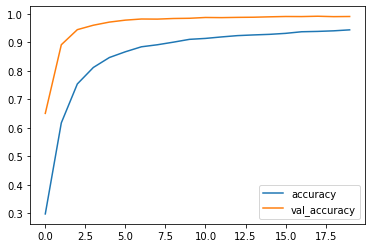

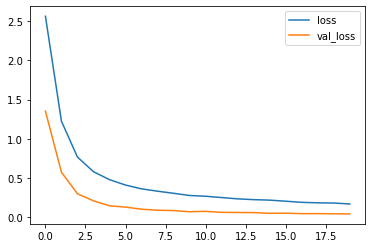

In [21]:
evaluation = pd.DataFrame(model.history.history)
evaluation[['accuracy', 'val_accuracy']].plot()
evaluation[['loss', 'val_loss']].plot()

In [22]:
test_path = 'traffic_sign_dataset/Test'
!rm traffic_sign_dataset/Test/GT-final_test.csv

In [23]:
#defining a function that will scale images
from PIL import Image

def scaling(test_images, test_path):
    images = []

    image_path = test_images
    
    for x in image_path:
        img = Image.open(test_path + '/' + x)
        img = img.resize((50,50))
        img = np.array(img)
        images.append(img)

    #Converting images into numpy array
    images = np.array(images)
    #The pixel value of each image ranges between 0 and 255
    #Dividing each image by 255 will scale the values between 0 and 1. This is also known as normalization.
    images = images/255

    return images

In [33]:
test_images = scaling(sorted(os.listdir(test_path)),test_path)

In [34]:
test = pd.read_csv('traffic_sign_dataset/Test.csv')
y_test = test['ClassId'].values
y_test

array([16,  1, 38, ...,  6,  7, 10])

In [38]:
y_pred = model.predict(test_images);
y_pred

395/395 [==============================] - 1s 3ms/step


array([[3.9085807e-21, 2.3396478e-17, 3.0762369e-20, ..., 2.0706295e-19,
        1.7682091e-17, 5.9128497e-10],
       [1.5539540e-10, 9.9999857e-01, 1.4307203e-07, ..., 2.0486741e-21,
        3.9310776e-31, 4.3392104e-29],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 1.5147249e-22,
        4.5481249e-34, 1.7702431e-31],
       ...,
       [7.4745312e-09, 1.3765617e-07, 1.2935098e-04, ..., 3.4778690e-04,
        2.2860696e-03, 3.4401536e-02],
       [8.4942184e-07, 3.9941358e-05, 3.6759895e-05, ..., 6.1608371e-06,
        5.3215255e-11, 9.6498889e-07],
       [7.3876100e-11, 2.8321887e-09, 1.4237908e-07, ..., 5.6640591e-08,
        1.4057133e-10, 9.6806139e-07]], dtype=float32)

In [40]:
# predict_x=model.predict(test_images) 
y_pred=np.argmax(y_pred,axis=1)

In [41]:
# Storing all lables
all_lables = ['Speed limit (20km/h)','Speed limit (30km/h)','Speed limit (50km/h)','Speed limit (60km/h)',
              'Speed limit (70km/h)','Speed limit (80km/h)','End of speed limit (80km/h)','Speed limit (100km/h)',
              'Speed limit (120km/h)','No passing','No passing for vechiles over 3.5 metric tons',
              'Right-of-way at the next intersection','Priority road','Yield','Stop','No vechiles',
              'Vechiles over 3.5 metric tons prohibited','No entry','General caution','Dangerous curve to the left',
              'Dangerous curve to the right','Double curve','Bumpy road','Slippery road','Road narrows on the right',
              'Road work','Traffic signals','Pedestrians','Children crossing','Bicycles crossing','Beware of ice/snow',
              'Wild animals crossing','End of all speed and passing limits','Turn right ahead','Turn left ahead',
              'Ahead only','Go straight or right','Go straight or left','Keep right','Keep left','Roundabout mandatory',
              'End of no passing','End of no passing by vechiles over 3.5 metric']

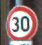

In [42]:
# Visualize test image
img = Image.open(test_path + '/00001.png')
img

In [43]:
# Original label
print("Original label : ",all_lables[y_test[1]])

Original label :  Speed limit (30km/h)


In [44]:
# Predicted label
print("Predicted label : ",all_lables[y_pred[1]])

Predicted label :  Speed limit (30km/h)


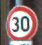

In [55]:
# Visualize test image
img = Image.open(test_path + '/00001.png')
img